<a href="https://colab.research.google.com/github/Rique3012/TransCal2/blob/main/Cilindro_Transferencia_Calor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regime Permanente

(200, 200)


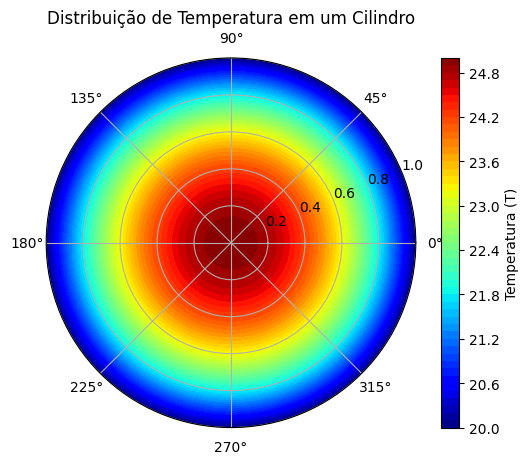

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 10     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
num_points = 200  # Número de pontos no diâmetro do fio

# Função para calcular a temperatura
def calculate_temperature(r, T0, S, R, K):
    return T0 + (S * R**2 / (4 * K)) * (1 - (r / R)**2)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)
T = calculate_temperature(r, T0, S, R, K)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Convertendo para coordenadas cartesianas
X = r * np.cos(theta)
Y = r * np.sin(theta)

# Mapeando as temperaturas para o grid
T_grid = calculate_temperature(r, T0, S, R, K)
print(np.shape(T_grid))

# Configurar o plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
fig.colorbar(c, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
plt.show()


# Regime Transiente

KeyboardInterrupt: 

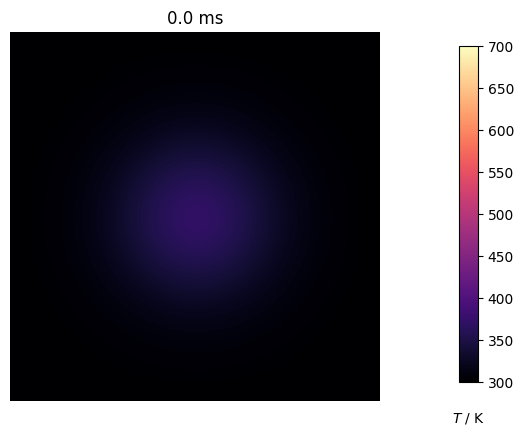

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.

Tcool, Thot = 300, 700

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, dr, cx, cy = 0, 1, 5, 5
ri2, ro2 = r**2, (r+dr)**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if ri2 < p2 < ro2:
            u0[i,j] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 500
fig = plt.figure()
ax = fig.add_subplot()
# The initial image: interpolate for smoothness and use a perceptually uniform
# sequential colourmap.
im = ax.imshow(u0, cmap=plt.get_cmap('magma'), vmin=Tcool, vmax=Thot,
               interpolation='bicubic')
ax.set_axis_off()
ax.set_title('0.0 ms')
# Add in the colourbar on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)

def animate(i):
    """Advance the simulation and animation by one time step."""
    global u0, u
    u0, u = do_timestep(u0, u)
    ax.set_title('{:.1f} ms'.format(i*dt*300))
    im.set_data(u.copy())

interval = 300*dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False,
                              interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show(ani)


In [ ]:
import pygame
pygame.init()
largura,altura = 800,600
screen = pygame.display.set_mode((largura,altura))

pygame.draw.circle(screen,(255,0,0),(400,300),50)
pygame.display.flip()
rodando = True
while rodando:
  screen.fill((0,0,0))
  for event in pygame.event.get():
    if event.type == pygame.QUIT:
      rodando = False
pygame.quit()

KeyboardInterrupt: 

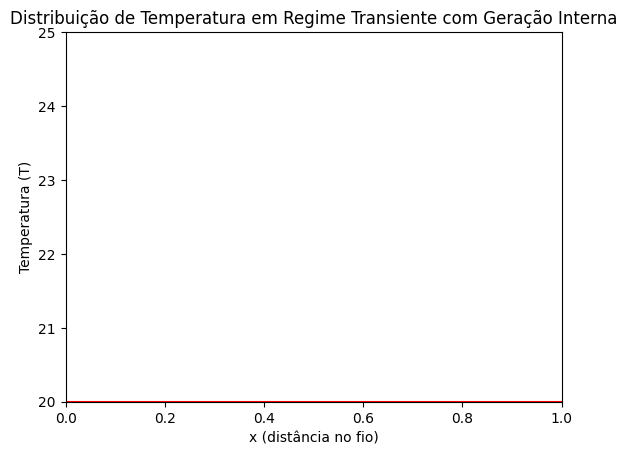

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
T0 = 20 # Temperatura inicial
S = 10 # Taxa de geração interna de calor
R = 1 # Comprimento do fio
K = 0.5 # Condutividade térmica
rho = 1.0 # Densidade do material
c = 1.0 # Capacidade calorífica específica
alpha = K / (rho * c) # Difusividade térmica
num_points = 200 # Número de pontos no comprimento do fio
dx = R / (num_points - 1)
dt = 0.0005 # Passo de tempo
num_steps = 2000 # Número de passos de tempo

# Inicialização do array de temperatura
T = np.full(num_points, T0)
x = np.linspace(0, R, num_points)

# Função para o passo de tempo
def step(T, dx, dt, alpha, num_points, S, rho, c):
    T_new = T.copy()
    for i in range(1, num_points-1):
        d2T_dx2 = (T[i+1] - 2*T[i] + T[i-1]) / dx**2
        term1 = alpha * d2T_dx2
        generation_term = S / (rho * c)
        T_new[i] = T[i] + dt * (term1 + generation_term)
    return T_new

# Configurações do plot
fig, ax = plt.subplots()
line, = ax.plot(x, T, 'r-')
ax.set_xlim(0, R)
ax.set_ylim(T0, T0 + (S * R**2) / (4 * K))
ax.set_xlabel('x (distância no fio)')
ax.set_ylabel('Temperatura (T)')
ax.set_title('Distribuição de Temperatura em Regime Transiente com Geração Interna')

# Função de animação
def update(frame):
    global T
    for _ in range(10): # Múltiplas atualizações de tempo por frame para suavizar a animação
        T = step(T, dx, dt, alpha, num_points, S, rho, c)
    line.set_ydata(T)
    return line,

# Criar animação
ani = animation.FuncAnimation(fig, update, frames=num_steps//10, interval=50, blit=True)

# Exibir o plot
plt.show(ani)

In [ ]:
import pygame
import numpy as np
import math

# Parâmetros da simulação
T0 = 20 # Temperatura inicial
S = 10 # Taxa de geração interna de calor
R = 100 # Raio do cilindro (ajustado para caber na tela)
K = 0.5 # Condutividade térmica
rho = 1.0 # Densidade do material
c = 1.0 # Capacidade calorífica específica
alpha = K / (rho * c) # Difusividade térmica
num_points = 200 # Número de pontos no raio do cilindro
dr = R / (num_points - 1)
dt = 0.001 # Passo de tempo
frames = 1000 # Número de frames na animação

# Inicializar Pygame
pygame.init()
WIDTH, HEIGHT = 800, 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Distribuição de Temperatura em um Cilindro")
clock = pygame.time.Clock()

# Inicialização do array de temperatura
T = np.full(num_points, T0)
r = np.linspace(0, R, num_points)

# Função para o passo de tempo
def step(T, dr, dt, alpha, r, num_points, S, rho, c):
    T_new = T.copy()
    for i in range(1, num_points-1):
        d2T_dr2 = (T[i+1] - 2*T[i] + T[i-1]) / dr**2
        dT_dr = (T[i+1] - T[i-1]) / (2*dr)
        term1 = alpha * (d2T_dr2 + (1/r[i])*dT_dr)
        generation_term = S / (rho * c)
        T_new[i] = T[i] + dt * (term1 + generation_term)
    return T_new

# Função para desenhar a tela
def draw_temperature_distribution(T):
    screen.fill((0, 0, 0))
    for i in range(num_points):
        for j in range(num_points):
            x = (i - num_points // 2) * (2 * R) / num_points
            y = (j - num_points // 2) * (2 * R) / num_points
            r_index = int(math.sqrt(x**2 + y**2) * (num_points-1) / R)
            if r_index < num_points:
                temperature = T[r_index]
                color_value = int(255 * (temperature - T0) / ((S * R**2) / (4 * K)))
                color_value = max(0, min(255, color_value)) # Limitando o valor da cor entre 0 e 255
                color = (color_value, 0, 255 - color_value)
                pygame.draw.circle(screen, color, (int(WIDTH / 2 + x), int(HEIGHT / 2 + y)), 1)
    pygame.display.flip()

# Loop principal da animação
t = 0
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    for _ in range(10): # Multiplicando steps por frame para simulação mais suave
        T = step(T, dr, dt, alpha, r, num_points, S, rho, c)
    draw_temperature_distribution(T)
    t += dt
    clock.tick(30) # Limitar a 30 FPS

pygame.quit()

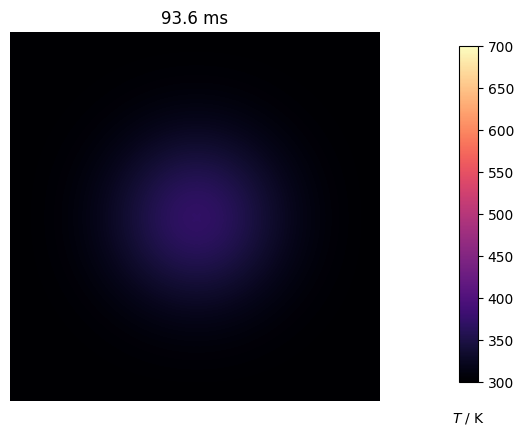

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.

Tcool, Thot = 300, 700

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, dr, cx, cy = 0, 1, 5, 5
ri2, ro2 = r**2, (r+dr)**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if ri2 < p2 < ro2:
            u0[i,j] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 500
fig = plt.figure()
ax = fig.add_subplot()
# The initial image: interpolate for smoothness and use a perceptually uniform
# sequential colourmap.
im = ax.imshow(u0, cmap=plt.get_cmap('magma'), vmin=Tcool, vmax=Thot,
               interpolation='bicubic')
ax.set_axis_off()
ax.set_title('0.0 ms')
# Add in the colourbar on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)

def animate(i):
    """Advance the simulation and animation by one time step."""
    global u0, u
    u0, u = do_timestep(u0, u)
    ax.set_title('{:.1f} ms'.format(i*dt*150))
    im.set_data(u.copy())

interval = 150*dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False,
                              interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show(ani)

Tentativa fusão dos códigos

[20. 20. 20. ... 20. 20. 20.]


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x79b13754e830> (for post_execute):


TypeError: 'NoneType' object is not callable

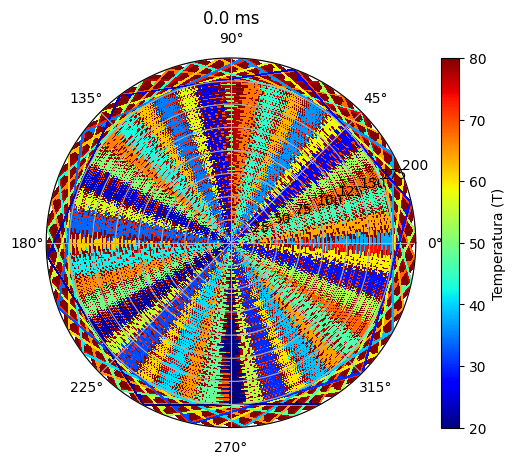

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 1000     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
alfa = 4   # Difusividade térmica
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)
T = np.tile(u,(num_points,1))

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')

# Simulação
def do_timestep(u):
  counter = 0
  while counter < tempo:
    u0 = u.copy()

    u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K * S
    for i in range(1, num_points - 1):
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K * S

    counter += dt
    T = np.tile(u,(num_points,1))

    #print(f"Temperatura média: {np.average(u)}ºC")

    # Atualiza o plot
    pcm.set_array(T)
    ax.set_title('{:.1f} ms'.format(counter))
    plt.pause(0.01)

print(T.ravel())
plt.show()

# interval = 1 * dt
# ani = animation.FuncAnimation(fig, do_timestep(u), frames=nsteps, repeat=False, interval=interval)
# ani.save('heat_transfer.gif', writer='pillow')
# plt.show()








# Mapeando as temperaturas para o grid
#T_grid = np.tile(u0,(num_points,1))

# Configurar o plot
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
# fig.colorbar(c, ax=ax, label='Temperatura (T)')
# ax.set_title('Distribuição de Temperatura em um Cilindro')

# def animate(frame):
#     """Advance the simulation and animation by one time step."""
#     global u0, u
#     u0, u, T_grid = calculate_temperature(u0, u, dr, dt)
#     ax.set_title('{:.1f} ms'.format(frame * dt * 50))
#     c.set_data()
#     return c

# interval = 50 * dt
# ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
# ani.save('heat_transfer.gif', writer='pillow')
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 1000     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
alfa = 4   # Difusividade térmica
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)
T = np.tile(u,(num_points,1))

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')

# Simulação
def do_timestep(u):
    u0 = u.copy()

    u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K * S
    for i in range(1, num_points - 1):
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K * S

    T = np.tile(u,(num_points,1))
    return T
    #print(f"Temperatura média: {np.average(u)}ºC")


def animate(frame):
    # Atualiza o plot
    global u
    T = do_timestep(u)
    pcm.set_array(T)
    ax.set_title('{:.1f} ms'.format(frame * dt * 1))

interval = 1 * dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show()








# Mapeando as temperaturas para o grid
#T_grid = np.tile(u0,(num_points,1))

# Configurar o plot
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
# fig.colorbar(c, ax=ax, label='Temperatura (T)')
# ax.set_title('Distribuição de Temperatura em um Cilindro')

# def animate(frame):
#     """Advance the simulation and animation by one time step."""
#     global u0, u
#     u0, u, T_grid = calculate_temperature(u0, u, dr, dt)
#     ax.set_title('{:.1f} ms'.format(frame * dt * 50))
#     c.set_data()
#     return c

# interval = 50 * dt
# ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
# ani.save('heat_transfer.gif', writer='pillow')
# plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79b13754dab0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Cylinder size (radius), mm
r_max = 10.0
# intervals in r direction
dr = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.0

Tcool, Thot = 300, 700

nr = int(r_max / dr)

dr2 = dr * dr
dt = dr2 / (2 * D)  # Adjusted time step

u0 = Tcool * np.ones(nr)  # Temperature array (only along radius)
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr
r, dr_initial, cx, cy = 0, 1, 5, 5
ri2, ro2 = r**2, (r + dr_initial)**2
for i in range(nr):
    rad = i * dr
    if ri2 < rad < ro2:
        u0[i] = Thot

def do_timestep(u0, u, dr, dt, D):
    # Propagate with forward-difference in time, central-difference in space (only along radius)
    for i in range(1, nr - 1):
        ur = (u0[i + 1] - 2 * u0[i] + u0[i - 1]) / dr2
        u[i] = u0[i] + D * dt * ur

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 1000
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
r = np.linspace(0, r_max, nr)
theta = np.linspace(0, 2 * np.pi, 100)  # Using a fixed number of points for theta
R, Theta = np.meshgrid(r, theta)  # Creating a meshgrid for plotting

# Reshape u0 to be compatible with pcolormesh
# by repeating it along the theta dimension
# using np.tile and the shape of Theta.
initial_data = np.tile(u0[:, np.newaxis], (1, Theta.shape[1]))

# The issue was with the shape of the data passed to pcolormesh.
# We need to ensure that the shape of the temperature data matches the
# shape of the grid defined by R and Theta.
# Instead of np.tile(u0, (2,1)), we use initial_data, which has
# the correct shape.
im = ax.pcolormesh(Theta, R, initial_data, cmap=plt.get_cmap('magma'), vmin=Tcool, vmax=Thot)
ax.set_title('Distribuição de Temperatura em um Cilindro')
# Add in the colorbar on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)

def animate(i):
    """Advance the simulation and animation by one time step."""
    global u0, u
    u0, u = do_timestep(u0, u, dr, dt, D)
    ax.set_title('{:.1f} ms'.format(i * dt * 50))
    im.set_array(u.copy().ravel())

interval = 50 * dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show(ani)

<ipython-input-6-5e4fe9d57355>:39: RuntimeWarning: overflow encountered in scalar divide
  utheta = (u0[i, j+1] - 2 * u0[i, j] + u0[i, j-1]) / (r**2 * dtheta2)
<ipython-input-6-5e4fe9d57355>:40: RuntimeWarning: invalid value encountered in scalar add
  u[i, j] = u0[i, j] + D * dt * (ur + utheta + (u0[i+1, j] - u0[i-1, j]) / (2 * r * dr))
<ipython-input-6-5e4fe9d57355>:39: RuntimeWarning: invalid value encountered in scalar subtract
  utheta = (u0[i, j+1] - 2 * u0[i, j] + u0[i, j-1]) / (r**2 * dtheta2)


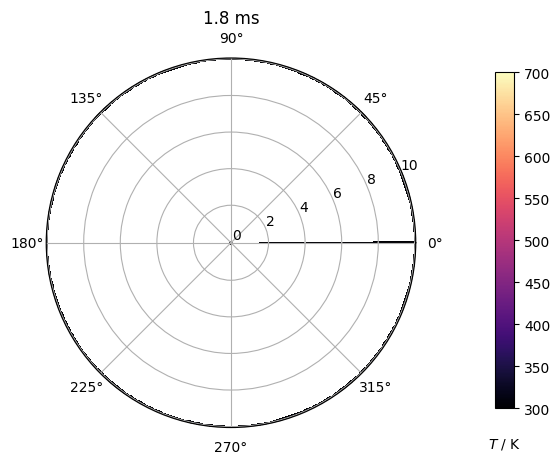

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# cylinder size (radius), mm
r_max = 10.0
# intervals in r, theta directions
dr = 0.1
dtheta = np.pi / 180 # 1 degree intervals
# Thermal diffusivity of steel, mm2.s-1
D = 4.0

Tcool, Thot = 300, 700

nr, ntheta = int(r_max / dr), int(2 * np.pi / dtheta)

dr2 = dr * dr
dtheta2 = dtheta * dtheta
dt = dr2 * dtheta2 / (2 * D * (dr2 + dtheta2))

u0 = Tcool * np.ones((nr, ntheta))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr
r, dr_initial, cx, cy = 0, 1, 5, 5
ri2, ro2 = r**2, (r + dr_initial)**2
for i in range(nr):
    for j in range(ntheta):
        rad = i * dr
        if ri2 < rad < ro2:
            u0[i, j] = Thot

def do_timestep(u0, u, dr, dtheta, dt, D):
    # Propagate with forward-difference in time, central-difference in space
    for i in range(1, nr-1):
        for j in range(1, ntheta-1):
            r = i * dr
            ur = (u0[i+1, j] - 2 * u0[i, j] + u0[i-1, j]) / dr2
            utheta = (u0[i, j+1] - 2 * u0[i, j] + u0[i, j-1]) / (r**2 * dtheta2)
            u[i, j] = u0[i, j] + D * dt * (ur + utheta + (u0[i+1, j] - u0[i-1, j]) / (2 * r * dr))

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 1000
fig = plt.figure()
ax = fig.add_subplot(polar=True)
# The initial image: interpolate for smoothness and use a perceptually uniform sequential colormap.
r = np.linspace(0, r_max, nr)
theta = np.linspace(0, 2 * np.pi, ntheta)
R, Theta = np.meshgrid(r, theta, indexing='ij')
im = ax.pcolormesh(Theta, R, u0, cmap=plt.get_cmap('magma'), vmin=Tcool, vmax=Thot)
ax.set_title('0.0 ms')
# Add in the colorbar on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)

def animate(i):
    """Advance the simulation and animation by one time step."""
    global u0, u
    u0, u = do_timestep(u0, u, dr, dtheta, dt, D)
    ax.set_title('{:.1f} ms'.format(i * dt * 50))
    im.set_array(u.copy().ravel())

interval = 50 * dt
ani = animation.FuncAnimation(fig, animate, frames=nsteps, repeat=False, interval=interval)
ani.save('heat_transfer.gif', writer='pillow')
plt.show(ani)


In [ ]:
import numpy as np
a = np.array([0, 1, 2])
#np.tile(a, 2)
np.tile(a, (3, 1))
#np.tile(a, (2, 1, 2))

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [ ]:
import numpy as np
# creating an array
myarray1 = np.array([[1, 2, 3], [4, 5, 6]])

# calling the ravel() function
myarray2 = np.ravel(myarray1, order = "K")

print(myarray2)

# checking the size of the imput and output arrays
print(myarray1.size)
print(myarray2.size)

[1 2 3 4 5 6]
6
6
